# Exploratory Data Analysis: Indian Liver Patient Dataset (ILPD)

Death by liver cirrhosis continues to increase, given the increase in alcohol consumption rates, chronic hepatitis infections, and obesity-related liver disease. Notwithstanding the high mortality of this disease, liver diseases do not affect all sub-populations equally. The early detection of pathology is a determinant of patient outcomes, yet female patients appear to be marginalized when it comes to early diagnosis of liver pathology. The dataset comprises 584 patient records collected from the NorthEast of Andhra Pradesh, India. The prediction task is to determine whether a patient suffers from liver disease based on the information about several biochemical markers, including albumin and other enzymes required for metabolism.

## 1. Setup and Configuration

First, we'll import the necessary libraries for data manipulation, statistical analysis, and visualization. We also set up our plotting styles and create a directory to save our visualizations.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, shapiro
import warnings
import os
from pathlib import Path

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout'] = True

RESULTS_DIR = Path('results/ilpd/figures')
RESULTS_DIR = Path('../../../../results/ilpd/figures')

print("Libraries imported successfully")
print(f"Results directory created at: {RESULTS_DIR}")

Libraries imported successfully
Results directory created at: ../../../../results/ilpd/figures


## 2. Data Loading and Initial Inspection

We load the dataset from the raw data directory and perform an initial inspection to understand its structure, data types, and basic statistics.

In [35]:
file_path = "../../../../data/raw/Indian_Liver_Patient_Dataset_ILPD.csv"

column_names = ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G_Ratio', 'Selector']
df = pd.read_csv(file_path, names=column_names)

print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nFirst 5 rows:")
display(df.head())

print("\n")
print("Dataset Information:")
df.info()

print("\n")
print("Descriptive Statistics:")
display(df.describe().round(2))

Dataset shape: 583 rows × 11 columns

First 5 rows:


,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G_Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1




Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        583 non-null    int64  
 1   Gender     583 non-null    object 
 2   TB         583 non-null    float64
 3   DB         583 non-null    float64
 4   Alkphos    583 non-null    int64  
 5   Sgpt       583 non-null    int64  
 6   Sgot       583 non-null    int64  
 7   TP         583 non-null    float64
 8   ALB        583 non-null    float64
 9   A/G_Ratio  579 non-null    float64
 10  Selector   583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


Descriptive Statistics:


,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G_Ratio,Selector
count,583.00,583.00,583.00,583.00,583.00,583.00,583.00,583.00,579.00,583.00
mean,44.75,3.30,1.49,290.58,80.71,109.91,6.48,3.14,0.95,1.29
std,16.19,6.21,2.81,242.94,182.62,288.92,1.09,0.80,0.32,0.45
min,4.00,0.40,0.10,63.00,10.00,10.00,2.70,0.90,0.30,1.00
25%,33.00,0.80,0.20,175.50,23.00,25.00,5.80,2.60,0.70,1.00
50%,45.00,1.00,0.30,208.00,35.00,42.00,6.60,3.10,0.93,1.00
75%,58.00,2.60,1.30,298.00,60.50,87.00,7.20,3.80,1.10,2.00
max,90.00,75.00,19.70,2110.00,2000.00,4929.00,9.60,5.50,2.80,2.00


### Features

* **Age:** (Integer) The patient's age in years.
    * *Note:* Any patient whose age exceeded 89 is listed as being 90.
* **Gender:** (Binary) The gender of the patient.
* **TB:** (Continuous) Total Bilirubin.
* **DB:** (Continuous) Direct Bilirubin.
* **Alkphos:** (Integer) Alkaline Phosphotase.
* **Sgpt:** (Integer) Alamine Aminotransferase.
* **Sgot:** (Integer) Aspartate Aminotransferase.
* **TP:** (Continuous) Total Proteins.
* **ALB:** (Continuous) Albumin.
* **A/G Ratio:** (Continuous) Albumin and Globulin Ratio.

### Target Variable

* **Selector:** (Binary) This is the class label used to predict whether a patient has liver disease.
    * *Context:* The dataset contains 416 records for patients *with* liver disease and 167 records for patients *without* liver disease.

## 3. Data Quality Assessment

A crucial step is to assess the quality of the data by checking for missing values, duplicate records, and validating data ranges.

In [38]:
print("Missing Values Analysis")
print("\n")

missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_pct
})

missing_summary = missing_df[missing_df['Missing Count'] > 0]
if len(missing_summary) > 0:
    print(missing_summary)
    print(f"\nTotal missing values: {missing_counts.sum()}")
else:
    print("No missing values detected!")

print(f"\nData completeness: {(1 - missing_counts.sum() / (len(df) * len(df.columns))) * 100:.2f}%")

Missing Values Analysis


           Missing Count  Percentage
A/G_Ratio              4    0.686106

Total missing values: 4

Data completeness: 99.94%


In [40]:
print("\nDuplicate Rows Analysis")
print("\n")

duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates} ({duplicates/len(df)*100:.2f}%)")

if duplicates > 0:
    print("\nSample duplicate rows:")
    display(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head(10))


Duplicate Rows Analysis


Duplicate rows: 13 (2.23%)

Sample duplicate rows:


,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G_Ratio,Selector
137,18,Male,0.8,0.2,282,72,140,5.5,2.5,0.8,1
138,18,Male,0.8,0.2,282,72,140,5.5,2.5,0.8,1
142,30,Male,1.6,0.4,332,84,139,5.6,2.7,0.9,1
143,30,Male,1.6,0.4,332,84,139,5.6,2.7,0.9,1
173,31,Male,0.6,0.1,175,48,34,6.0,3.7,1.6,1
174,31,Male,0.6,0.1,175,48,34,6.0,3.7,1.6,1
25,34,Male,4.1,2.0,289,875,731,5.0,2.7,1.1,1
26,34,Male,4.1,2.0,289,875,731,5.0,2.7,1.1,1
107,36,Male,0.8,0.2,158,29,39,6.0,2.2,0.5,2
108,36,Male,0.8,0.2,158,29,39,6.0,2.2,0.5,2


### Data Quality Summary

- **Missing Values**: Only 4 values are missing, all in the `A/G_Ratio` column. This is a very small amount (0.07% of the total data) and can be easily imputed.
- **Duplicates**: There are 13 duplicate rows (2.23%). These should be removed before modeling to prevent bias.
- **Data Ranges**: The data ranges seem plausible, with the age being capped at 90 as noted in the dataset description. There are no negative values for biochemical markers.

## 4. Target Variable Analysis

Next, we analyze the distribution of the target variable, `Selector`, to understand the class balance and its implications for modeling.

In [44]:
# Map selector to meaningful labels for plotting
df['Disease_Status'] = df['Selector'].map({1: 'Liver Disease', 2: 'No Disease'})

print("Class Distribution Analysis")
print("\n")
print("Note: 1 = Liver Disease, 2 = No Disease\n")

class_dist = df['Selector'].value_counts().sort_index()
for cls, count in class_dist.items():
    disease_status = "Liver Disease" if cls == 1 else "No Liver Disease"
    print(f"  Class {cls} ({disease_status}): {count} patients ({count/len(df)*100:.2f}%)")

# Imbalance ratio
majority_class = class_dist.max()
minority_class = class_dist.min()
ir = majority_class / minority_class

print(f"\nImbalance Ratio (IR): {ir:.2f}")

Class Distribution Analysis


Note: 1 = Liver Disease, 2 = No Disease

  Class 1 (Liver Disease): 416 patients (71.36%)
  Class 2 (No Liver Disease): 167 patients (28.64%)

Imbalance Ratio (IR): 2.49


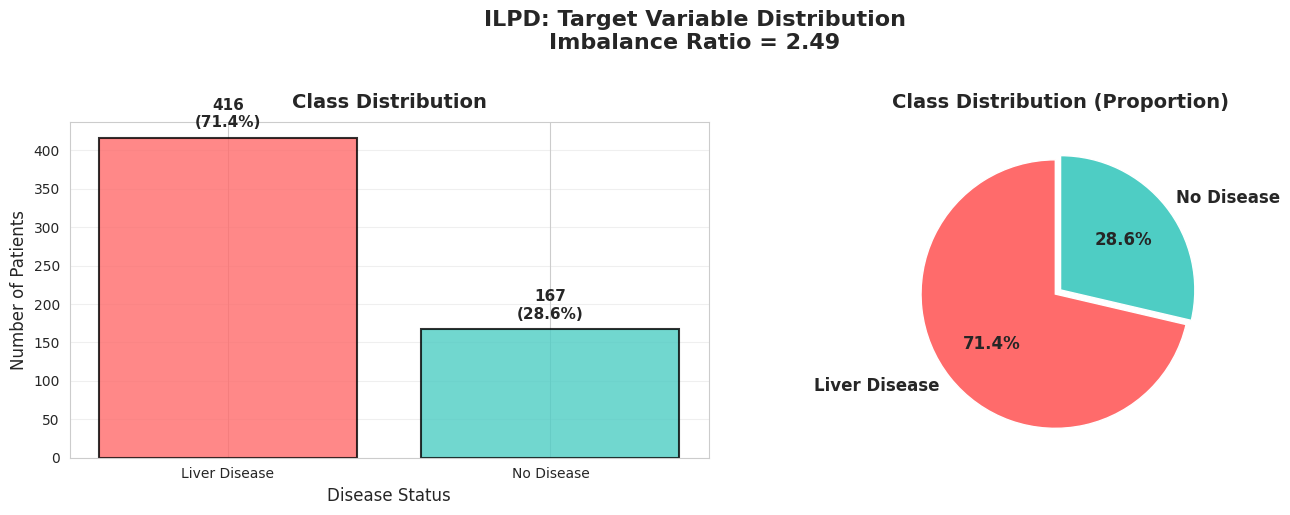

Visualization saved to: ../../../../results/ilpd/figures/01_target_distribution.png


In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#FF6B6B', '#4ECDC4']
counts = df['Disease_Status'].value_counts()
axes[0].bar(counts.index, counts.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold', pad=10)
axes[0].set_ylabel('Number of Patients', fontsize=12)
axes[0].set_xlabel('Disease Status', fontsize=12)
for i, (label, count) in enumerate(counts.items()):
    axes[0].text(i, count + 10, f'{count}\n({count/len(df)*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(counts.values, labels=counts.index, autopct='%1.1f%%',
           colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'},
           explode=[0.05, 0])
axes[1].set_title('Class Distribution (Proportion)', fontsize=14, fontweight='bold', pad=10)

plt.suptitle(f'ILPD: Target Variable Distribution\nImbalance Ratio = {ir:.2f}',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '01_target_distribution.png', bbox_inches='tight')
plt.show()

print(f"Visualization saved to: {RESULTS_DIR / '01_target_distribution.png'}")

## 5. Gender Distribution Analysis

We investigate the gender distribution in the dataset and its relationship with liver disease status. This is important for identifying potential sampling biases and for later analysis of gender-specific effects.

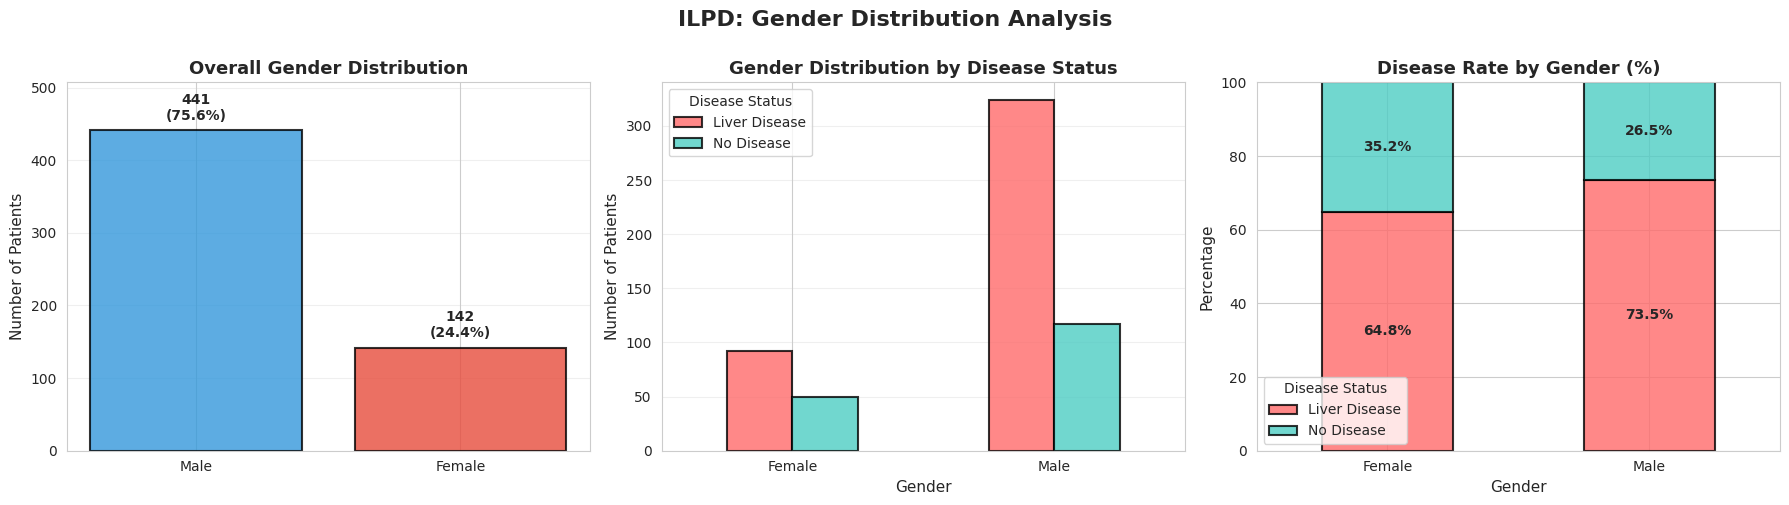

Visualization saved to: ../../../../results/ilpd/figures/02_gender_distribution.png


In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Overall gender distribution
gender_counts = df['Gender'].value_counts()
colors_gender = ['#3498DB', '#E74C3C']
axes[0].bar(gender_counts.index, gender_counts.values, color=colors_gender, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_title('Overall Gender Distribution', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Patients', fontsize=11)
axes[0].set_ylim(0, max(gender_counts.values) * 1.15)
for i, (label, count) in enumerate(gender_counts.items()):
    axes[0].text(i, count + 10, f'{count}\n({count/len(df)*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# Gender by disease status (counts)
gender_disease = pd.crosstab(df['Gender'], df['Disease_Status'])
gender_disease.plot(kind='bar', ax=axes[1], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_title('Gender Distribution by Disease Status', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Number of Patients', fontsize=11)
axes[1].set_xlabel('Gender', fontsize=11)
axes[1].legend(title='Disease Status', fontsize=10)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(axis='y', alpha=0.3)

# Gender by disease status (percentage)
gender_disease_pct = pd.crosstab(df['Gender'], df['Disease_Status'], normalize='index') * 100
gender_disease_pct.plot(kind='bar', stacked=True, ax=axes[2], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[2].set_title('Disease Rate by Gender (%)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Percentage', fontsize=11)
axes[2].set_xlabel('Gender', fontsize=11)
axes[2].legend(title='Disease Status', fontsize=10)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)
axes[2].set_ylim(0, 100)

# Add percentage labels
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%.1f%%', label_type='center', fontweight='bold')

plt.suptitle('ILPD: Gender Distribution Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '02_gender_distribution.png', bbox_inches='tight')
plt.show()

print(f"Visualization saved to: {RESULTS_DIR / '02_gender_distribution.png'}")

### Gender Analysis Summary

- **Gender Imbalance**: The dataset is heavily skewed towards males (75.6%) compared to females (24.4%). This under-representation of female patients could affect the generalizability of a model.
- **Disease Rate**: Males have a slightly higher rate of liver disease (73.5%) compared to females (64.8%), though the association is not statistically significant at the p<0.05 level (p=0.060).

## 6. Age Distribution Analysis

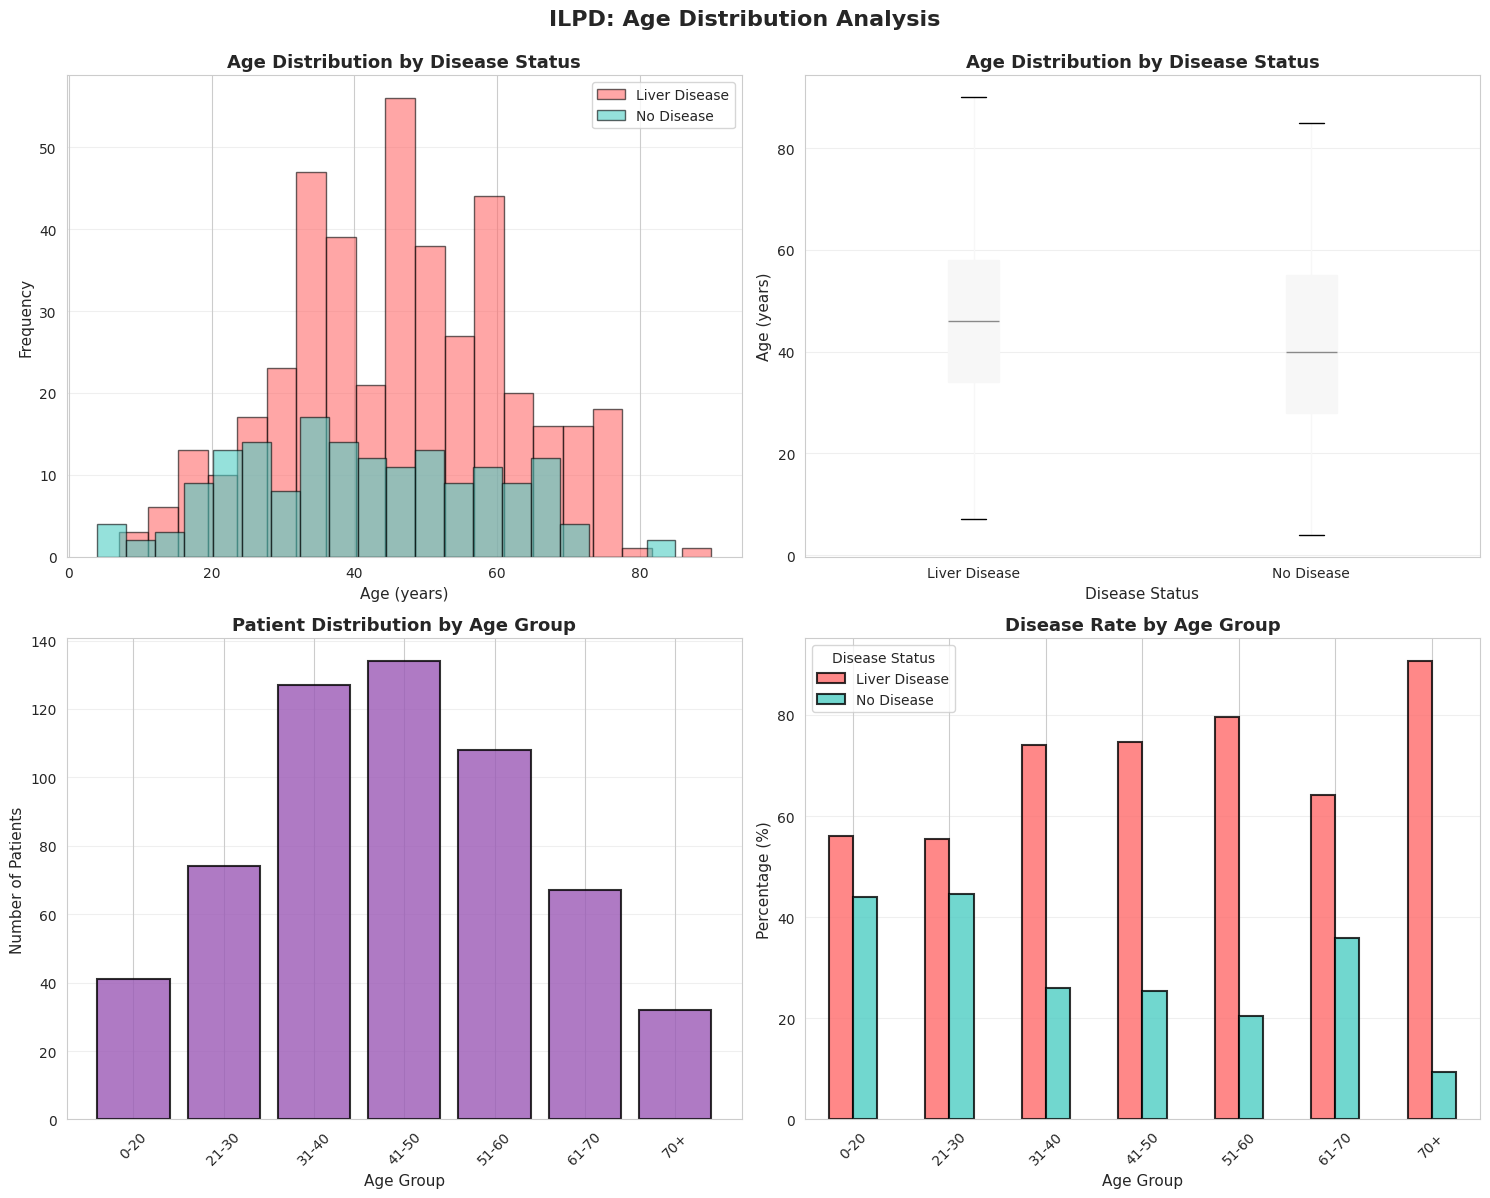

Visualization saved to: ../../../../results/ilpd/figures/03_age_distribution.png


In [52]:
# Bin age into groups for analysis
age_bins = [0, 20, 30, 40, 50, 60, 70, 90]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '70+']
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Visualize age distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Age histogram by disease status
disease_colors = {'Liver Disease': '#FF6B6B', 'No Disease': '#4ECDC4'}
for status in df['Disease_Status'].unique():
    data = df[df['Disease_Status'] == status]['Age']
    axes[0, 0].hist(data, bins=20, alpha=0.6, label=status,
                   color=disease_colors[status], edgecolor='black')
axes[0, 0].set_title('Age Distribution by Disease Status', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Age (years)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# Age boxplot by disease status
df.boxplot(column='Age', by='Disease_Status', ax=axes[0, 1], patch_artist=True, grid=False)
axes[0, 1].set_title('Age Distribution by Disease Status', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Disease Status', fontsize=11)
axes[0, 1].set_ylabel('Age (years)', fontsize=11)
plt.sca(axes[0, 1])
plt.xticks(rotation=0)
axes[0, 1].get_figure().suptitle('')  
axes[0, 1].grid(axis='y', alpha=0.3)

# Age groups bar chart
age_group_counts = df['Age_Group'].value_counts().sort_index()
axes[1, 0].bar(range(len(age_group_counts)), age_group_counts.values,
              color='#9B59B6', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xticks(range(len(age_group_counts)))
axes[1, 0].set_xticklabels(age_group_counts.index, rotation=45)
axes[1, 0].set_title('Patient Distribution by Age Group', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Number of Patients', fontsize=11)
axes[1, 0].set_xlabel('Age Group', fontsize=11)
axes[1, 0].grid(axis='y', alpha=0.3)

# Disease rate by age group
age_disease = pd.crosstab(df['Age_Group'], df['Disease_Status'], normalize='index') * 100
age_disease.plot(kind='bar', ax=axes[1, 1], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 1].set_title('Disease Rate by Age Group', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Percentage (%)', fontsize=11)
axes[1, 1].set_xlabel('Age Group', fontsize=11)
axes[1, 1].legend(title='Disease Status', fontsize=10)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('ILPD: Age Distribution Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '03_age_distribution.png', bbox_inches='tight')
plt.show()

print(f"Visualization saved to: {RESULTS_DIR / '03_age_distribution.png'}")

### Age Analysis Summary

- **Demographics**: The patient population is centered in middle age, with a median age of 45. The largest groups are 31-40 and 41-50 years old.
- **Disease and Age**: Patients with liver disease are, on average, older than healthy patients. The disease rate increases steadily with age, peaking at a very high 90.6% in the 70+ age group.

## 7. Analysis of Biochemical Markers

We will now analyze the distributions of the various biochemical markers to understand their characteristics and relationship to liver disease.

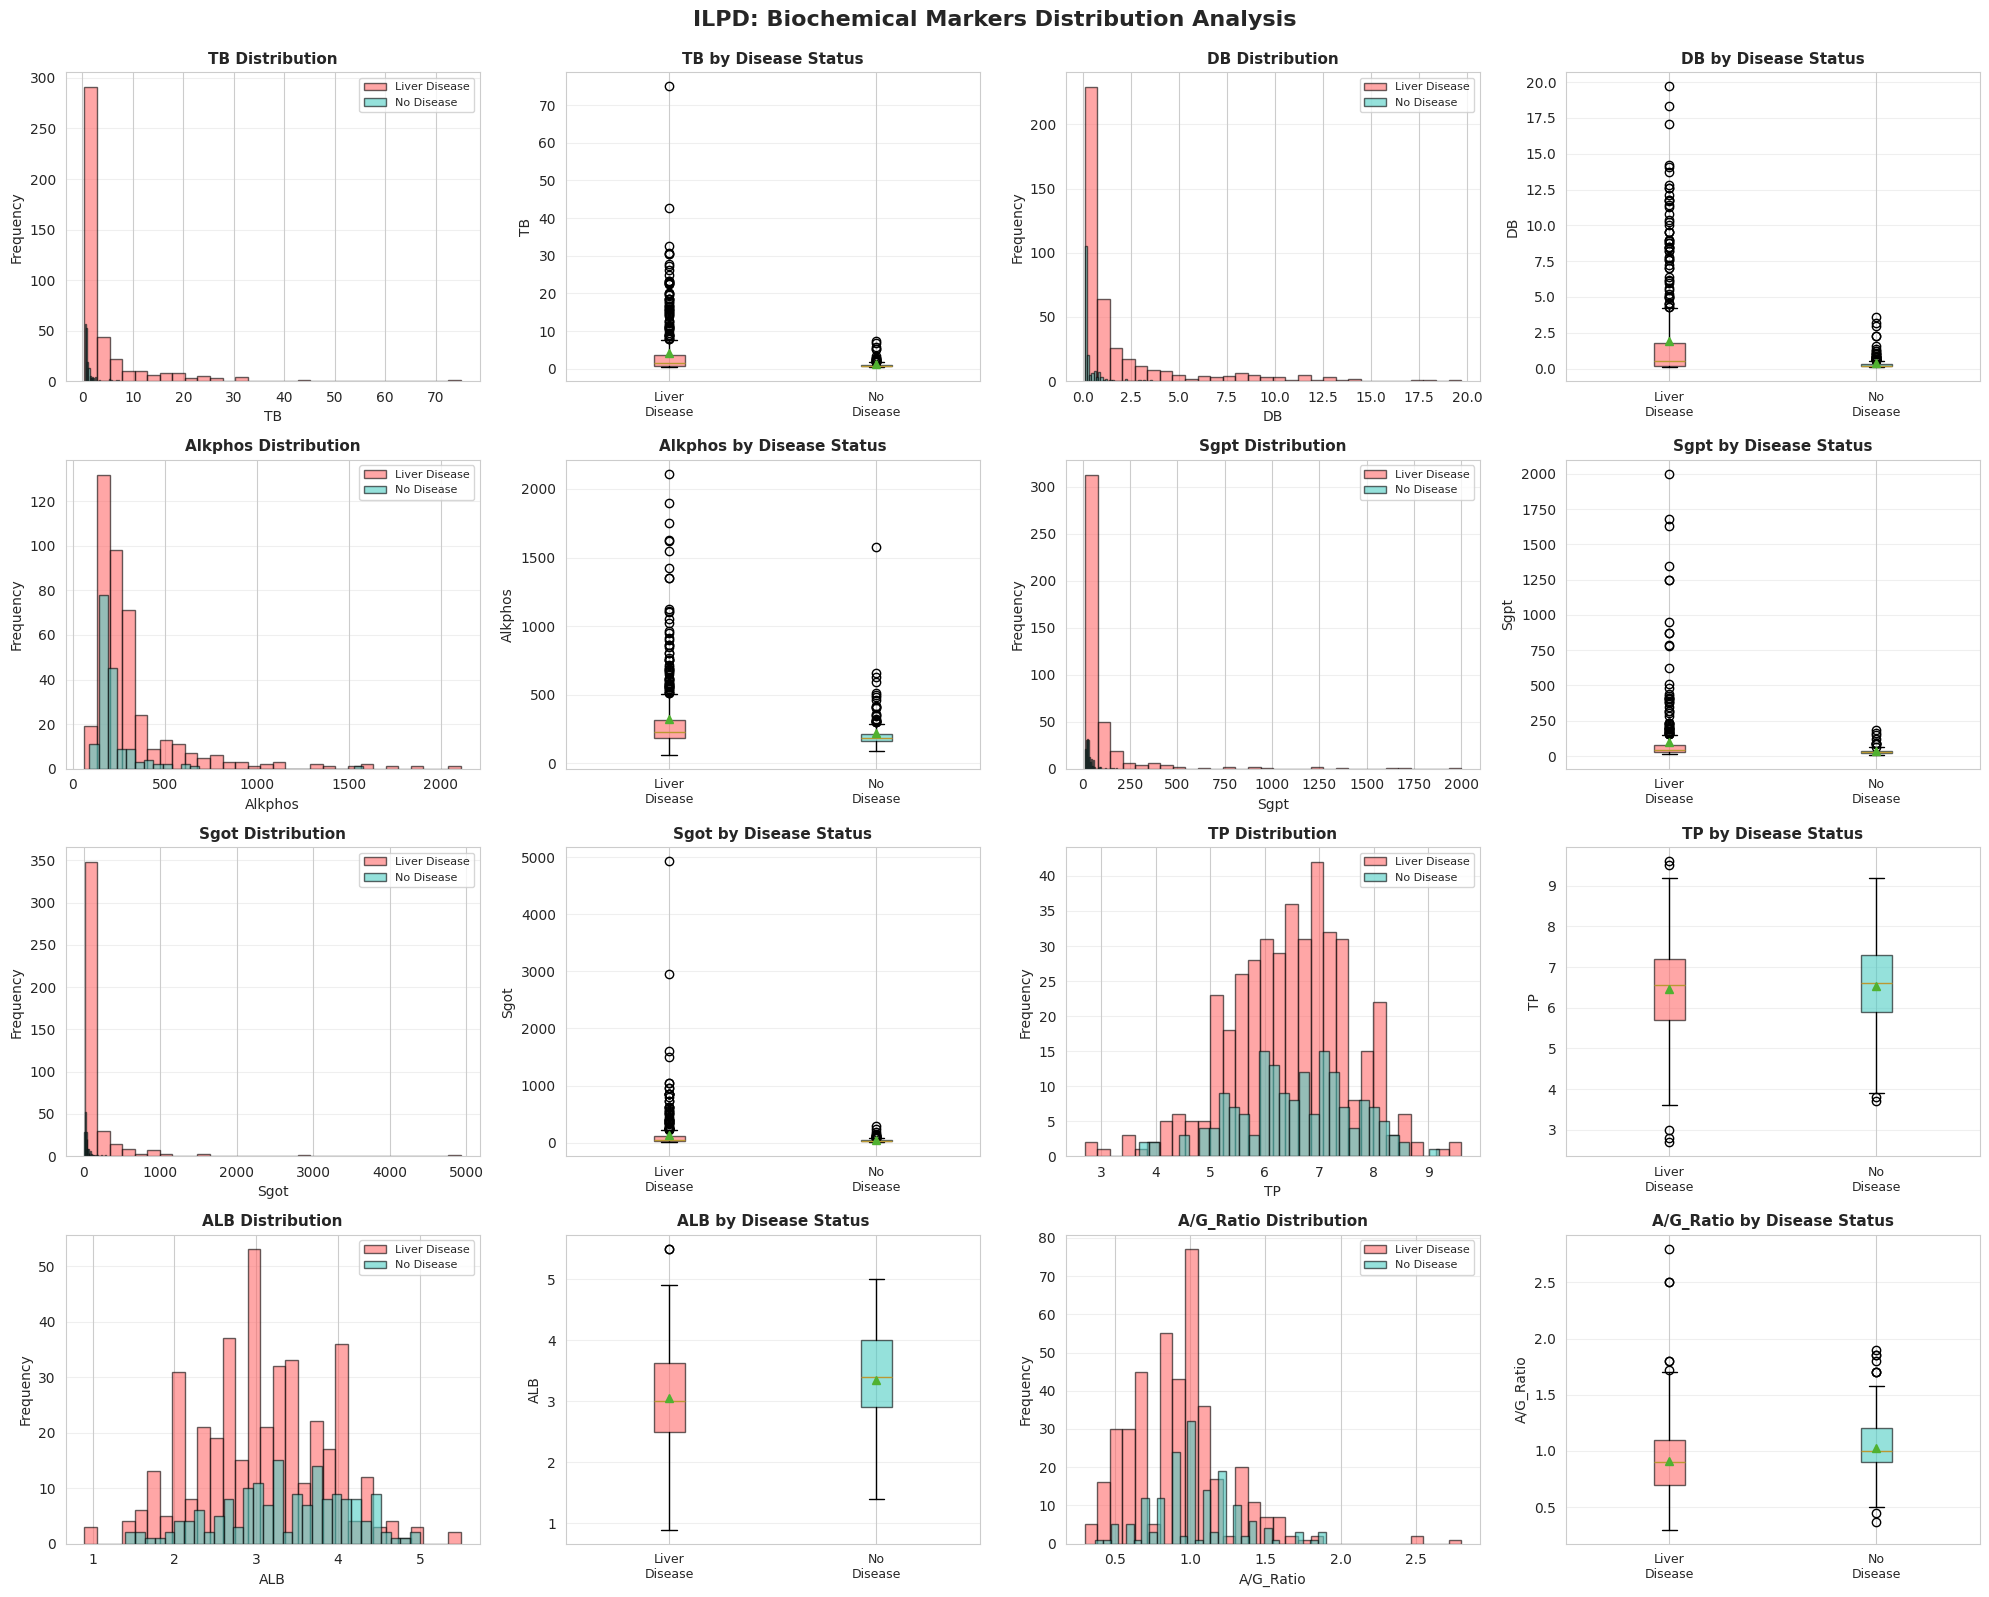

Visualization saved to: ../../../../results/ilpd/figures/04_biochemical_distributions.png


In [53]:
numerical_features_bio = ['TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G_Ratio']

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features_bio):
    # Histogram
    ax = axes[idx * 2]
    for status in df['Disease_Status'].unique():
        data = df[df['Disease_Status'] == status][feature].dropna()
        ax.hist(data, bins=30, alpha=0.6, label=status,
               color=disease_colors[status], edgecolor='black')
    ax.set_title(f'{feature} Distribution', fontsize=11, fontweight='bold')
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)

    # Boxplot
    ax = axes[idx * 2 + 1]
    data_to_plot = [df[df['Disease_Status'] == status][feature].dropna()
                    for status in ['Liver Disease', 'No Disease']]
    bp = ax.boxplot(data_to_plot, labels=['Liver Disease', 'No Disease'],
                   patch_artist=True, showmeans=True)
    for patch, color in zip(bp['boxes'], ['#FF6B6B', '#4ECDC4']):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax.set_title(f'{feature} by Disease Status', fontsize=11, fontweight='bold')
    ax.set_ylabel(feature, fontsize=10)
    ax.set_xticklabels(['Liver\nDisease', 'No\nDisease'], fontsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('ILPD: Biochemical Markers Distribution Analysis',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '04_biochemical_distributions.png', bbox_inches='tight')
plt.show()

print(f"Visualization saved to: {RESULTS_DIR / '04_biochemical_distributions.png'}")

### Biochemical Markers Summary

- **Distributions**: Most markers (`TB`, `DB`, `Alkphos`, `Sgpt`, `Sgot`) are heavily **right-skewed**. This indicates that most patients have values in the normal range, but a subset of patients (likely those with severe disease) have extremely high values.
- **Disease vs. Healthy**: For liver enzymes and bilirubin, the distributions for the 'Liver Disease' group are shifted significantly to the right (higher values) compared to the 'No Disease' group. Conversely, `ALB` and `A/G_Ratio` tend to be lower in patients with liver disease.

## 8. Correlation Analysis

We'll examine the correlations between features to identify relationships and potential multicollinearity, which can be problematic for some machine learning models.

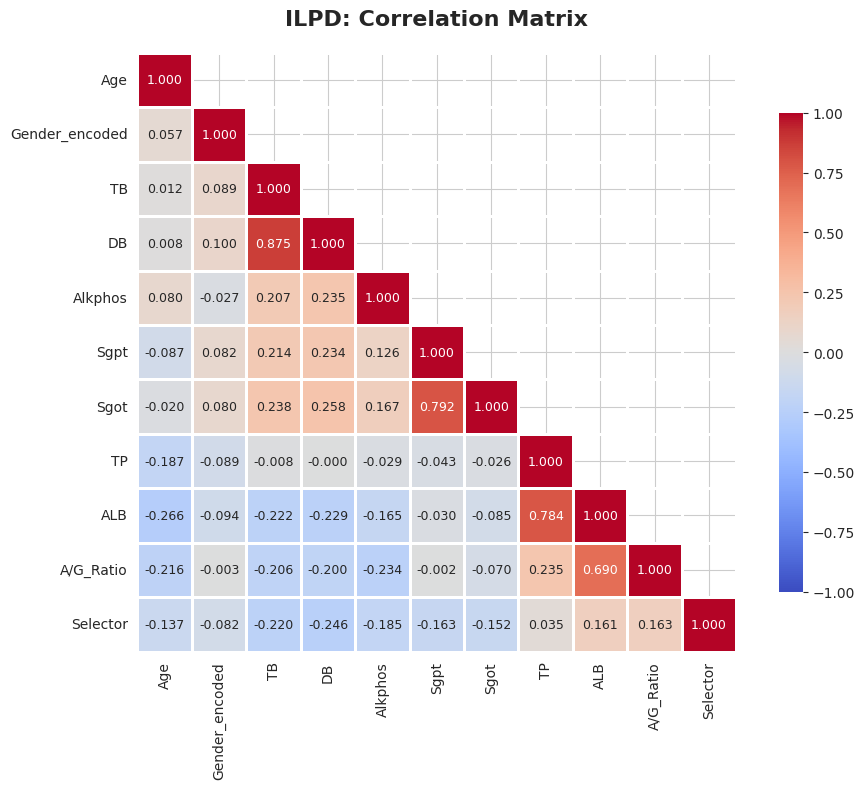

Visualization saved to: ../../../../results/ilpd/figures/05_correlation_heatmap.png


In [56]:
# Encode gender for correlation matrix
df_encoded = df.copy()
df_encoded['Gender_encoded'] = df_encoded['Gender'].map({'Male': 1, 'Female': 0})

features_for_corr = ['Age', 'Gender_encoded', 'TB', 'DB', 'Alkphos',
                     'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G_Ratio', 'Selector']
correlation_matrix = df_encoded[features_for_corr].corr()

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
           center=0, square=True, linewidths=1,
           cbar_kws={"shrink": 0.8}, mask=mask,
           vmin=-1, vmax=1, annot_kws={"fontsize": 9})
plt.title('ILPD: Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '05_correlation_heatmap.png', bbox_inches='tight')
plt.show()

print(f"Visualization saved to: {RESULTS_DIR / '05_correlation_heatmap.png'}")

## 10. Gender-Based Disparities Analysis

This section investigates a crucial question: do the biochemical markers work equally well for diagnosing liver disease in both males and females? Differences in effectiveness could lead to biased models.

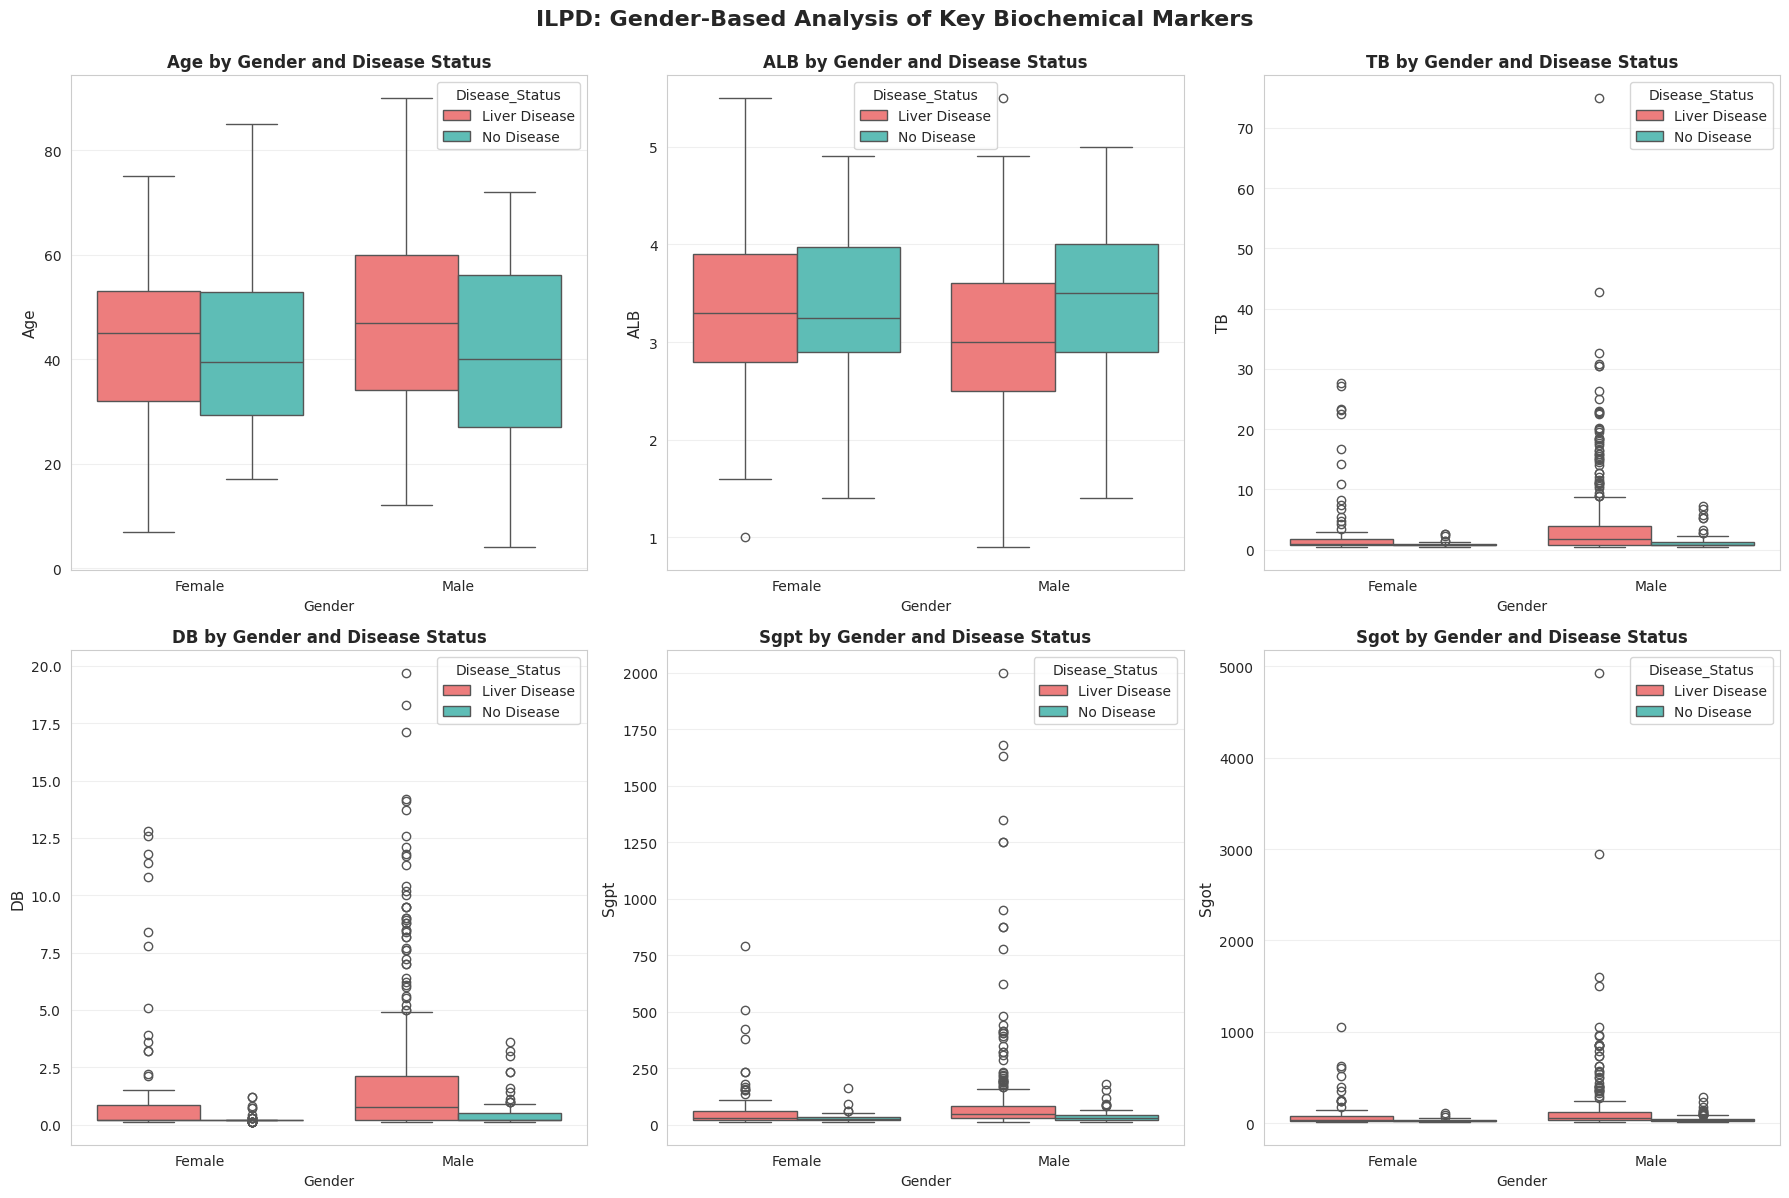

Visualization saved to: ../../../../results/ilpd/figures/07_gender_marker_analysis.png


In [59]:
# Visualize gender-based marker analysis
key_markers = ['Age', 'ALB', 'TB', 'DB', 'Sgpt', 'Sgot']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, marker in enumerate(key_markers):
    ax = axes[idx]
    sns.boxplot(x='Gender', y=marker, hue='Disease_Status', data=df, ax=ax, palette=colors)
    ax.set_title(f'{marker} by Gender and Disease Status', fontsize=12, fontweight='bold')
    ax.set_ylabel(marker, fontsize=11)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('ILPD: Gender-Based Analysis of Key Biochemical Markers',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '07_gender_marker_analysis.png', bbox_inches='tight')
plt.show()

print(f"Visualization saved to: {RESULTS_DIR / '07_gender_marker_analysis.png'}")